# In mem dataset

In [1]:
%matplotlib inline
import numpy.random as rd
import matplotlib.pyplot as plt
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station, load_or_create_experiment, \
    initialise_database, Measurement, load_by_run_spec, load_by_guid
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement


Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\Jens-work\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\Jens-work\.qcodes\logs\210614-28632-qcodes.log


In what follows, we shall define some utility functions as well as declare our dummy instruments. We, then, add these instruments to a ``Station`` object. 

The dummy dmm is setup to generate an output depending on the values set on the dummy dac simulating a real experiment.

In [2]:
# preparatory mocking of physical setup

dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement(name='dmm', setter_instr=dac)

station = qc.Station(dmm, dac)

In [3]:
# now make some silly set-up and tear-down actions

def veryfirst():
    print('Starting the measurement')

def numbertwo(inst1, inst2):
    print('Doing stuff with the following two instruments: {}, {}'.format(inst1, inst2))
    
def thelast():
    print('End of experiment')

**Note** that database and experiments may be missing.

If this is the first time you create a dataset, the underlying database file has
most likely not been created. The following cell creates the database file. Please
refer to documentation on [`The Experiment Container`](The-Experiment-Container.ipynb) for details.

Furthermore, datasets are associated to an experiment. By default, a dataset (or "run")
is appended to the latest existing experiments. If no experiment has been created,
we must create one. We do that by calling the `load_or_create_experiment` function.

Here we explicitly pass the loaded or created experiment to the `Measurement` object to ensure that we are always
using the `performing_meas_using_parameters_and_dataset` `Experiment` created within this tutorial.

In [4]:
initialise_database()
exp = load_or_create_experiment(
    experiment_name='performing_meas_using_parameters_and_dataset',
    sample_name="no sample"
)

And then run an experiment:

In [5]:
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone

meas.add_before_run(veryfirst, ())  # add a set-up action
meas.add_before_run(numbertwo, (dmm, dac))  # add another set-up action
meas.add_after_run(thelast, ())  # add a tear-down action

meas.write_period = 0.5

with meas.run() as datasaver:             
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
    
    dataset1D = datasaver.dataset  # convenient to have for data access and plotting

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrumentWithMeasurement: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 938. 
End of experiment


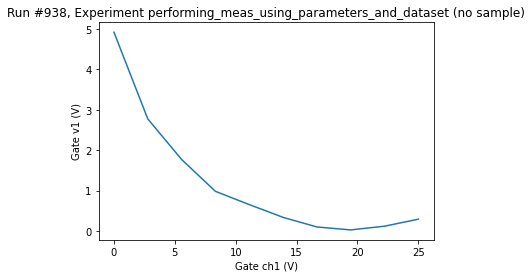

In [6]:
ax, cbax = plot_dataset(dataset1D)

In [7]:
from qcodes.dataset.data_set_in_memory import DataSetInMem

In [8]:
with meas.run(dataset_class=DataSetInMem) as datasaver:             
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
    datasetinmem = datasaver.dataset

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrumentWithMeasurement: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 939. 
End of experiment


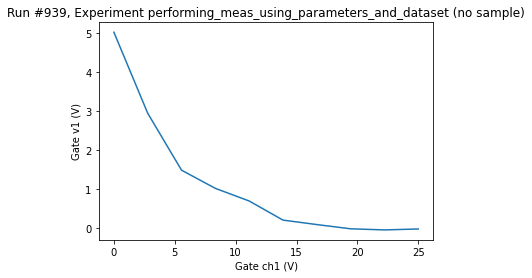

In [9]:
ax, cbax = plot_dataset(datasetinmem)

In [10]:
datasetinmem.run_id

939

In [11]:
datasetinmem.export("netcdf", path='.')

In [12]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 8C24-64FA

 Directory of C:\Users\Jens-work\source\repos\Qcodes\docs\examples\DataSet

14/06/2021  14.20    <DIR>          .
14/06/2021  14.20    <DIR>          ..
14/06/2021  14.18    <DIR>          .ipynb_checkpoints
14/06/2021  11.25           694.157 Accessing-data-in-DataSet.ipynb
14/06/2021  11.25            17.673 Benchmarking.ipynb
14/06/2021  11.25    <DIR>          Cache
14/06/2021  11.25            78.943 DataSet-class-walkthrough.ipynb
14/06/2021  11.25            85.237 Dataset_Performance.ipynb
14/06/2021  11.25            16.283 Extracting-runs-from-one-DB-file-to-another.ipynb
14/06/2021  11.25            78.918 import-data-from-legacy-dat-files.ipynb
14/06/2021  14.19            52.454 In memory dataset exp.ipynb
14/06/2021  11.25           107.861 Linking to parent datasets.ipynb
14/06/2021  11.25            31.470 Measuring X as a function of time.ipynb
14/06/2021  11.25           341.976 Offline Plotting Tuto

In [13]:
import xarray as xr

In [14]:
loaded_data = xr.load_dataset(f"qcodes_{datasetinmem.run_id}.nc")

In [15]:
loaded_data.attrs

{'ds_name': 'results',
 'sample_name': 'no sample',
 'exp_name': 'performing_meas_using_parameters_and_dataset',
 'snapshot': '{"station": {"instruments": {"dmm": {"functions": {}, "submodules": {}, "__class__": "qcodes.tests.instrument_mocks.DummyInstrumentWithMeasurement", "parameters": {"IDN": {"__class__": "qcodes.instrument.parameter.Parameter", "full_name": "dmm_IDN", "value": {"vendor": null, "model": "dmm", "serial": null, "firmware": null}, "raw_value": {"vendor": null, "model": "dmm", "serial": null, "firmware": null}, "ts": "2021-06-14 14:20:21", "label": "IDN", "name": "IDN", "instrument": "qcodes.tests.instrument_mocks.DummyInstrumentWithMeasurement", "instrument_name": "dmm", "inter_delay": 0, "vals": "<Anything>", "post_delay": 0, "unit": ""}, "v1": {"__class__": "qcodes.tests.instrument_mocks.DmmExponentialParameter", "full_name": "dmm_v1", "value": 0.2920969562502864, "raw_value": 0.2920969562502864, "ts": "2021-06-14 14:20:21", "label": "Gate v1", "name": "v1", "instr